#*The goal of this notebook is try to find duplicated videos across 4 mice!*


# (1) Install dependencies & mount Drive

In [ ]:
!pip install tqdm einops --quiet # Display the progress
!pip install ydata-profiling # To generate the report profiling of a dataframe
!pip install umap-learn # Install umap
# Clean installation outputs`
from IPython.display import clear_output
clear_output()

In [ ]:
# A. Imports
import torch
import torch.nn as nn
import torchvision
from torchvision.models.video import R2Plus1D_18_Weights
from torchvision import transforms
from einops import rearrange
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
from ydata_profiling import ProfileReport
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import umap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib.cm import tab10
# extract first 6 colors of tab10
tab6 = ListedColormap(tab10.colors[:6])

In [ ]:
# B. Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# C. Videos path shortcut
VIDEO_DIR = "/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Mice_Merged_Videos"
video_files = sorted([os.path.join(VIDEO_DIR,f) for f in os.listdir(VIDEO_DIR) if f.endswith(".npy")])
print(f"We have {len(video_files)} videos!.")

We have 2867 videos!.


# (2) Load an official video embedding model

We use [R(2+1)D-18, pretrained on Kinetics-400](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.video.r2plus1d_18.html).

The function torchvision.models.video.r2plus1d_18 constructs an 18-layer deep R(2+1)D network, a 3D Convolutional Neural Network (CNN) designed for video action recognition. The "R(2+1)D" architecture separates 3D convolutions into a 2D spatial convolution and a 1D temporal convolution, which improves performance and efficiency for video data. Find the original paper [here](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://arxiv.org/pdf/1711.11248&ved=2ahUKEwjJl56Oq52RAxWGhv0HHWhbMLgQFnoECDIQAQ&usg=AOvVaw08DRHkaqzlYFISALp9pC_j).

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = torchvision.models.video.r2plus1d_18(weights=R2Plus1D_18_Weights.DEFAULT) # let's update pretrained by weights=R2Plus1D_18_Weights.DEFAULT
model.fc = nn.Identity()   # remove classification head → 512-dim embedding
model = model.to(device).eval()

Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth


100%|██████████| 120M/120M [00:00<00:00, 193MB/s]


# (3) Preprocessing function

Torch video models expect (C, T, H, W) with 112×112 spatial resolution.

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((112,112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43216,0.394666,0.37645],
                         std=[0.22803,0.22145,0.216989])
])

# (4) Convert .npy videos to embeddings

We will:

 - sample 324 frames uniformly from the 324

 - transform each frame

 - stack into tensor (1, 3, 324, 112, 112)

 - run through the model → 512-dim embedding

In [ ]:
def load_video(path):
    v = np.load(path)  # (36,64,324)
    return np.transpose(v, (2,0,1))  # (T,H,W) : T= Time steps(frames), H = Height and W = Width

def sample_frames(video, num=324):
    T = video.shape[0]
    #idx = np.linspace(0, T-1, num).astype(int)
    idx = np.arange(num)
    return video[idx]

def preprocess_frames(frames):
    out = []
    for f in frames:
        f = ((f - f.min())/(f.max()-f.min()+1e-6)*255).astype(np.uint8)
        f3 = np.stack([f,f,f], axis=-1)  # grayscale → 3-channel
        out.append(transform(f3))
    return torch.stack(out)  # (T,3,112,112)

def get_video_embedding(path):
    vid = load_video(path)
    frames = sample_frames(vid, num=324)
    batch = preprocess_frames(frames)  # (32,3,112,112)

    batch = rearrange(batch, "t c h w -> 1 c t h w").to(device)
    with torch.no_grad():
        emb = model(batch).cpu().numpy().squeeze()  # (512,)
    return emb


# (5) Compute embeddings for all videos

In [ ]:
embeddings = []
for f in tqdm(video_files, desc="Embedding videos"):
    emb = get_video_embedding(f)
    embeddings.append(emb)

embeddings = np.vstack(embeddings)
print(embeddings.shape)  # (N, 512)

Embedding videos:   0%|          | 0/2867 [00:00<?, ?it/s]/tmp/ipython-input-3053387548.py:14: RuntimeWarning: invalid value encountered in cast
  f = ((f - f.min())/(f.max()-f.min()+1e-6)*255).astype(np.uint8)
Embedding videos: 100%|██████████| 2867/2867 [57:08<00:00,  1.20s/it]

(2867, 512)


In [ ]:
# Save embedding
np.save("/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/embeddings.npy", embeddings)
# Load saved embeddings
embeddings = np.load("/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/embeddings.npy")

In [ ]:
# Shape
print(f" Embedding shape : {embeddings.shape}.")

 Embedding shape : (2867, 512).


Great!, now, each video is a vector of length 512.

# **Plan A : K-means (K=6) and Projection in 2D**

# A.1. Clustering

In [ ]:

K = 6 # Number of classes within our dataset

kmeans = KMeans(n_clusters=K, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

print("Cluster labels shape:", cluster_labels.shape)
print("Counts per cluster:", np.bincount(cluster_labels))


Cluster labels shape: (2867,)
Counts per cluster: [453 789 159 829 178 459]


In [ ]:
# Compute the centroid of each cluster ; Centroid = mean embedding vector of all videos in cluster.
cluster_centroids = []

for k in range(K):  # K=6
    idx = np.where(cluster_labels == k)[0]
    centroid = embeddings[idx].mean(axis=0)
    cluster_centroids.append(centroid)

cluster_centroids = np.vstack(cluster_centroids)
print(cluster_centroids.shape)  # (6, 512)

(6, 512)


In [ ]:
# Find the representative video (closest to centroid) , We use cosine similarity or L2 distance.


representative_video_ids = []

for k in range(K):
    idx = np.where(cluster_labels == k)[0]
    cluster_embs = embeddings[idx]

    dists = pairwise_distances(
        cluster_embs,
        cluster_centroids[k][None,:],
        metric="cosine"
    ).squeeze()

    rep = idx[dists.argmin()]  # video ID
    representative_video_ids.append(rep)

representative_video_ids

[np.int64(2780),
 np.int64(2410),
 np.int64(1665),
 np.int64(961),
 np.int64(2230),
 np.int64(2451)]

/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Mice_Merged_Videos/Mouse_4__3_5__668.npy
/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Mice_Merged_Videos/Mouse_4__3_5__332.npy
/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Mice_Merged_Videos/Mouse_3__6_9__318.npy
/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Mice_Merged_Videos/Mouse_2__2_10__32.npy
/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Mice_Merged_Videos/Mouse_4__3_5__168.npy
/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Mice_Merged_Videos/Mouse_4__3_5__37.npy

 Plot representative videos


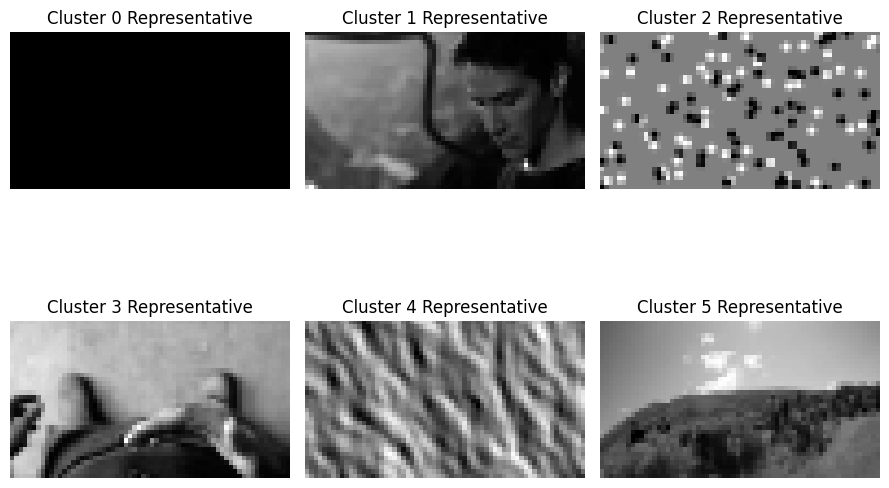

In [ ]:
# -------------------------
# Helpers
# -------------------------

def load_video(path):
    v = np.load(path)   # (36,64,324)
    return np.transpose(v, (2,0,1))  # (T,H,W)

def show_video(ax, video, title):
    """Draw a matplotlib animation inside a given axis."""
    ax.set_title(title)
    ax.axis("off")

    frame = ax.imshow(video[0], cmap="gray", animated=True)

    def animate(i):
        frame.set_array(video[i])
        return [frame]

    anim = FuncAnimation(
        fig, animate,
        frames=len(video),
        interval=50,
        blit=True
    )
    return anim

# ----------------------------------------------------------
# Get the 6 representative video paths (computed earlier)
# ----------------------------------------------------------
#print('\n Print classes')
representative_paths = [video_files[i] for i in representative_video_ids]
for rep in representative_paths:
    print(rep)


# Load all 6 videos
videos = [load_video(p) for p in representative_paths]

# ------------------------------------
# Plot 2×3 grid of the 6 representative videos
# ------------------------------------
print('\n Plot representative videos')
fig, axes = plt.subplots(2, 3, figsize=(9, 7))

animations = []
for ax, vid, idx in zip(axes.ravel(), videos, range(len(videos))):
    animations.append(
        show_video(ax, vid, title=f"Cluster {idx} Representative")#
    )

plt.tight_layout()
plt.show()

# A.2. 2D Projection of Embeddings (UMAP)

We use UMAP  which is somehow better than t-SNE for high-dimensional 512-D embeddings.

In [ ]:
reducer = umap.UMAP(n_neighbors=20, min_dist=0.1, metric="cosine")
emb_2d = reducer.fit_transform(embeddings)
print("UMAP 2D shape:", emb_2d.shape)

UMAP 2D shape: (2867, 2)


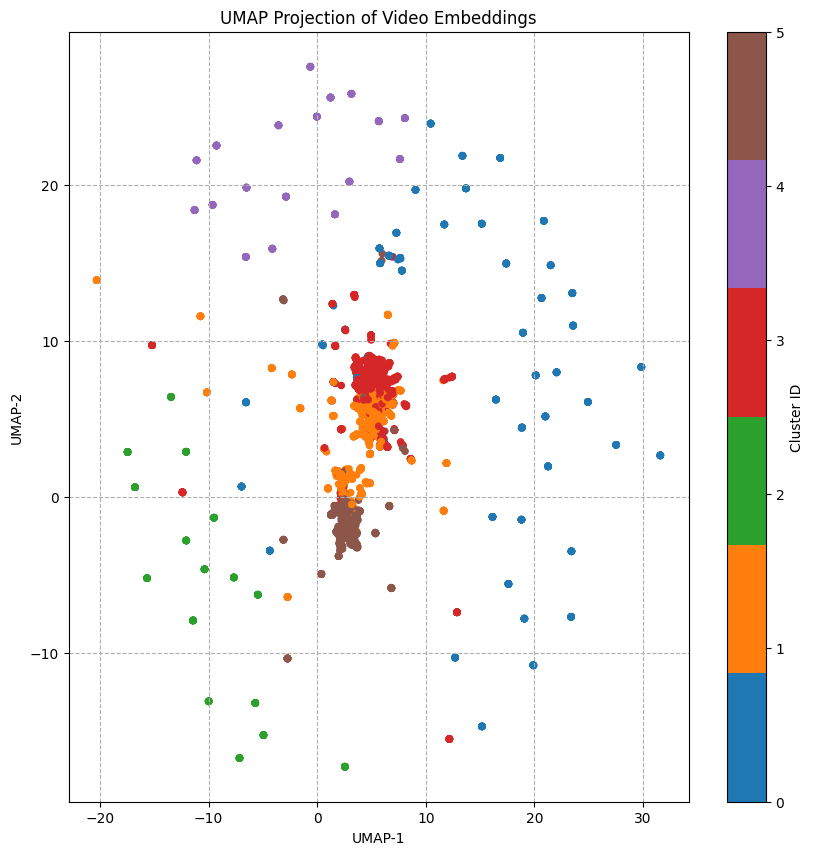

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=cluster_labels, cmap=tab6, s=20)
plt.title("UMAP Projection of Video Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label="Cluster ID")
plt.grid(linestyle='--')
plt.show()

In [ ]:
# UMAP in 3D
reducer_3d = umap.UMAP(
    n_neighbors=20,
    min_dist=0.1,
    metric="cosine",
    n_components=3,
    #random_state=42
)

emb_3d = reducer_3d.fit_transform(embeddings)
print("UMAP 3D shape:", emb_3d.shape)

UMAP 3D shape: (2867, 3)


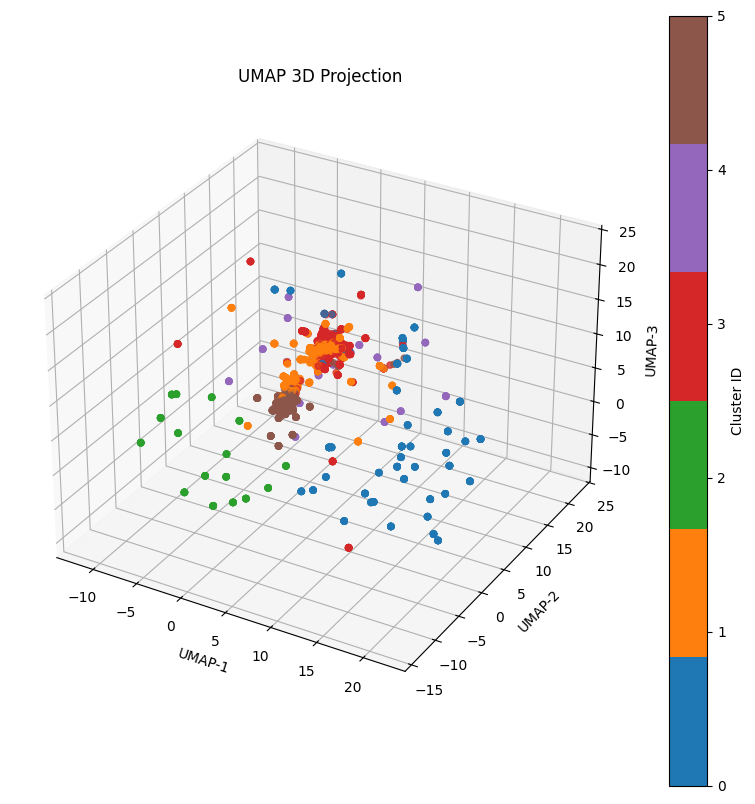

In [ ]:


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(
    emb_3d[:,0], emb_3d[:,1], emb_3d[:,2],
    c=cluster_labels, cmap=tab6, s=20
)

ax.set_title("UMAP 3D Projection")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")

plt.colorbar(p, label="Cluster ID")
plt.show()

# (6) Compute similarity matrix

In [ ]:
sim_matrix = cosine_similarity(embeddings)

In [ ]:
sim_matrix.shape

(2867, 2867)

Number of potential duplicates: 62943
Number of (exact) duplicates: 1633


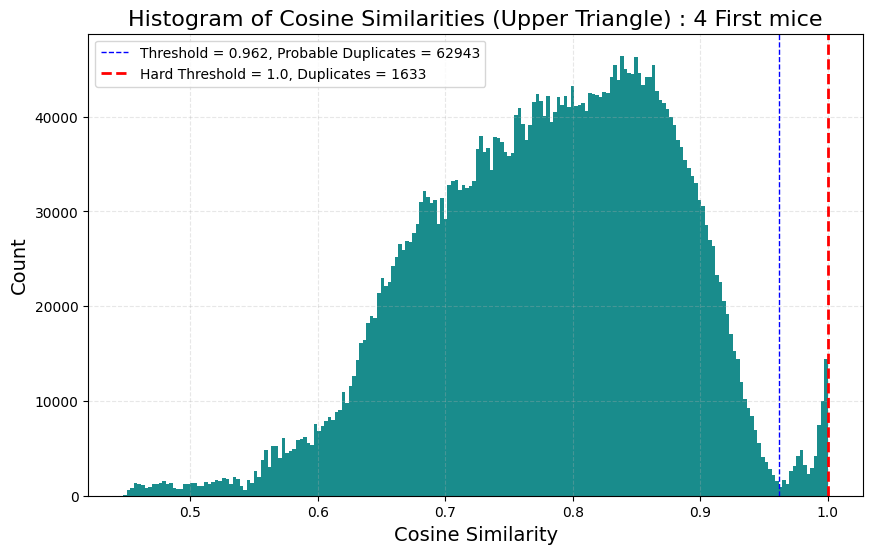

In [ ]:
# --- extract upper triangle (excluding diagonal) ---
i_upper = np.triu_indices_from(sim_matrix, k=1)
sim_values = sim_matrix[i_upper]

#Threshold
thr_1 = 0.962
thr_2 = 1.00
# Exact duplicates : theshold = thr_2
number_of_potential_duplicates = (sim_values >= thr_1).sum()
print(f"Number of potential duplicates: {number_of_potential_duplicates}")
number_of_duplicates = (sim_values >= thr_2).sum()
print(f"Number of (exact) duplicates: {number_of_duplicates}")
# --- plot histogram ---
plt.figure(figsize=(10, 6))
plt.hist(sim_values, bins=200,color='teal',alpha=0.9)
plt.title("Histogram of Cosine Similarities (Upper Triangle) : 4 First mice", fontsize=16)
# Plot a vertical line Thr = 0.99
plt.axvline(x=thr_1, color='blue', linestyle='--', linewidth=1,label=f"Threshold = {thr_1}, Probable Duplicates = {number_of_potential_duplicates}")
plt.axvline(x=thr_2, color='red', linestyle='--', linewidth=2,label=f"Hard Threshold = {thr_2}, Duplicates = {number_of_duplicates}")
plt.xlabel("Cosine Similarity", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.grid(linestyle="--",alpha=0.3)
plt.legend(loc='best')
plt.show()

In [ ]:
i_upper

(array([   0,    0,    0, ..., 2864, 2864, 2865]),
 array([   1,    2,    3, ..., 2865, 2866, 2866]))

In [ ]:
sim_values.shape

(4108411,)

# (7) Detect near-duplicate videos


In [ ]:
THRESH = thr_2

duplicates = []
N = len(video_files)
for i in range(N):
    for j in range(i+1, N):
        if sim_matrix[i,j] >= THRESH:
            duplicates.append((video_files[i], video_files[j], sim_matrix[i,j]))

print("Found duplicate pairs:", len(duplicates))
duplicates[:5]

Found duplicate pairs: 1633


[('/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Mice_Merged_Videos/Mouse_1__11_10__101.npy',
  '/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Mice_Merged_Videos/Mouse_1__11_10__210.npy',
  np.float32(1.0000001)),
 ('/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Mice_Merged_Videos/Mouse_1__11_10__101.npy',
  '/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Mice_Merged_Videos/Mouse_1__11_10__733.npy',
  np.float32(1.0000001)),
 ('/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Mice_Merged_Videos/Mouse_1__11_10__101.npy',
  '/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Mice_Merged_Videos/Mouse_1__11_10__95.npy',
  np.float32(1.0000001)),
 ('/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Mice_Merged_Videos/Mouse_1__11_10__102.npy',
  '/content/drive/MyDrive/PROJECTS_2025/M

# (8) Save results

In [ ]:
df = pd.DataFrame(duplicates, columns=["video_1","video_2","similarity"])
df.to_csv("/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Pure_Duplicate_Videos_Embedding_04_12_2025.csv", index=False)

In [ ]:
# Data Profiling for the new dataframe
df = pd.read_csv("/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Pure_Duplicate_Videos_Embedding_04_12_2025.csv")
df.head()

video_1  \
0  /content/drive/MyDrive/PROJECTS_2025/MDMC_SISS...   
1  /content/drive/MyDrive/PROJECTS_2025/MDMC_SISS...   
2  /content/drive/MyDrive/PROJECTS_2025/MDMC_SISS...   
3  /content/drive/MyDrive/PROJECTS_2025/MDMC_SISS...   
4  /content/drive/MyDrive/PROJECTS_2025/MDMC_SISS...   

                                             video_2  similarity  
0  /content/drive/MyDrive/PROJECTS_2025/MDMC_SISS...         1.0  
1  /content/drive/MyDrive/PROJECTS_2025/MDMC_SISS...         1.0  
2  /content/drive/MyDrive/PROJECTS_2025/MDMC_SISS...         1.0  
3  /content/drive/MyDrive/PROJECTS_2025/MDMC_SISS...         1.0  
4  /content/drive/MyDrive/PROJECTS_2025/MDMC_SISS...         1.0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1633 entries, 0 to 1632
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   video_1     1633 non-null   object 
 1   video_2     1633 non-null   object 
 2   similarity  1633 non-null   float64
dtypes: float64(1), object(2)
memory usage: 38.4+ KB


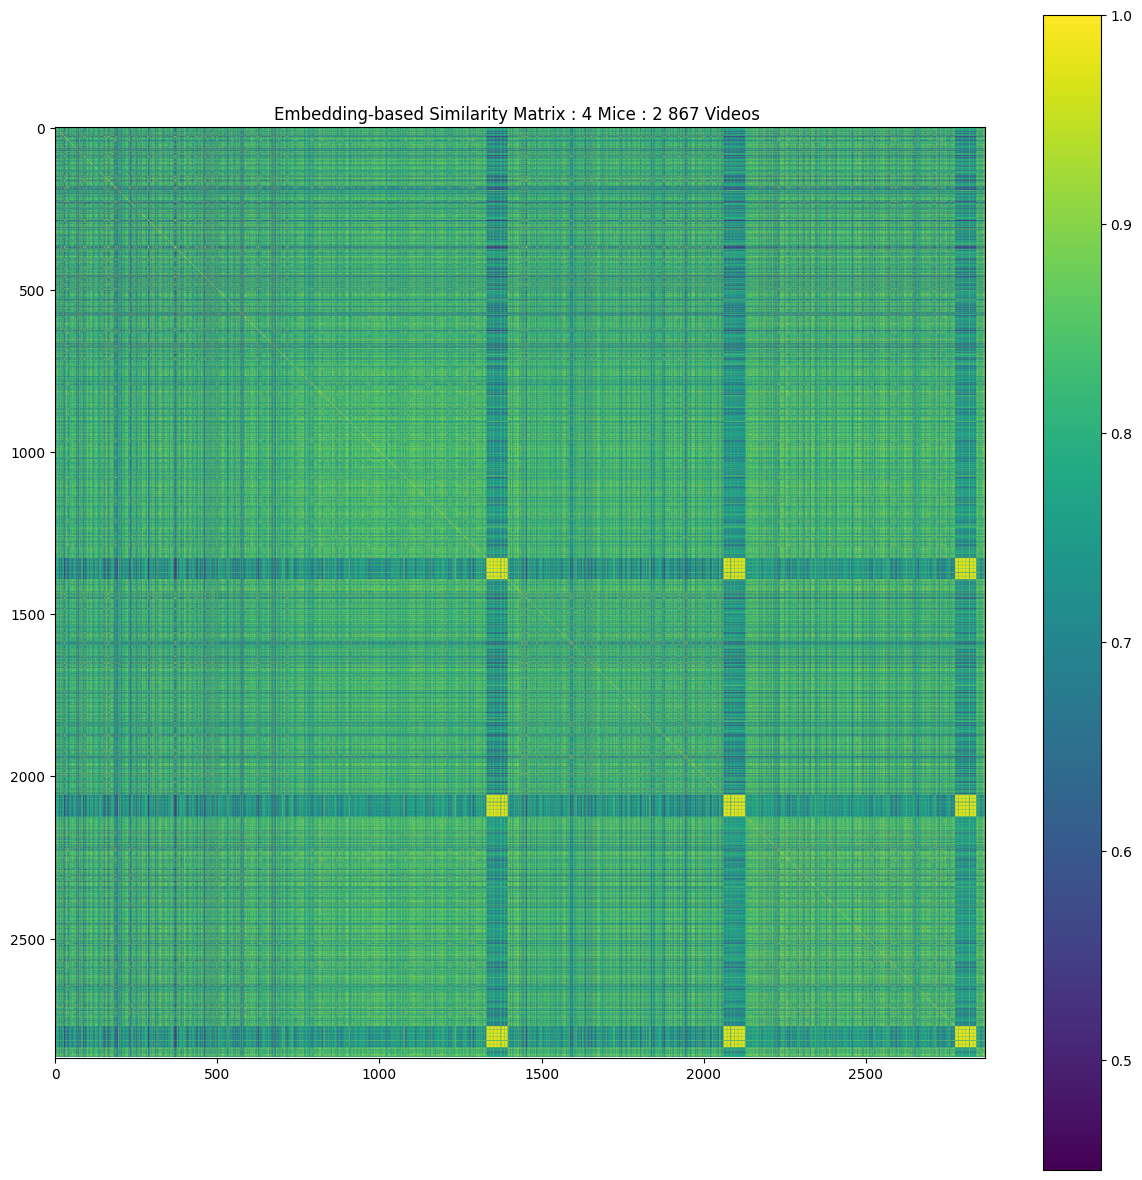

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(sim_matrix, cmap="viridis")
plt.colorbar()
plt.title("Embedding-based Similarity Matrix : 4 Mice : 2 867 Videos ")
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1633 entries, 0 to 1632
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   video_1     1633 non-null   object 
 1   video_2     1633 non-null   object 
 2   similarity  1633 non-null   float64
dtypes: float64(1), object(2)
memory usage: 38.4+ KB


In [ ]:
# Profiling the dataset
profile = ProfileReport(df, title="Profiling Report")
profile.to_file("/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Pure_Report_04_12_2025.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 3/3 [00:00<00:00, 26.61it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
profile

In [ ]:
import os
df_new = df.copy()
df_new['video_1'] = df_new['video_1'].apply(os.path.basename)
df_new['video_2'] = df_new['video_2'].apply(os.path.basename)
df_new.head()

video_1                  video_2  similarity
0  Mouse_1__11_10__101.npy  Mouse_1__11_10__210.npy         1.0
1  Mouse_1__11_10__101.npy  Mouse_1__11_10__733.npy         1.0
2  Mouse_1__11_10__101.npy   Mouse_1__11_10__95.npy         1.0
3  Mouse_1__11_10__102.npy  Mouse_1__11_10__254.npy         1.0
4  Mouse_1__11_10__104.npy  Mouse_1__11_10__206.npy         1.0

In [ ]:
df_new.to_csv("/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Short_Pure_Duplicate_Videos_Embedding_04_12_2025.csv", index=False)

In [ ]:
df_new = pd.read_csv("/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Short_Pure_Duplicate_Videos_Embedding_04_12_2025.csv")
df_new.head()

video_1                  video_2  similarity
0  Mouse_1__11_10__101.npy  Mouse_1__11_10__210.npy         1.0
1  Mouse_1__11_10__101.npy  Mouse_1__11_10__733.npy         1.0
2  Mouse_1__11_10__101.npy   Mouse_1__11_10__95.npy         1.0
3  Mouse_1__11_10__102.npy  Mouse_1__11_10__254.npy         1.0
4  Mouse_1__11_10__104.npy  Mouse_1__11_10__206.npy         1.0

In [ ]:
# Display unique values in video_1
unique_video1 = df_new['video_1'].unique()
print(f"Unique values in video_1: {len(unique_video1)}")

Unique values in video_1: 783


In [ ]:
#print("\nGroups:")
# Group video_2 lists by each unique video_1, resulting in a pandas Series
grouped_series = df_new.groupby('video_1')['video_2'].apply(list)

# Convert the Series into a DataFrame.
# 'video_1' becomes a column, and the lists of video_2 become another column named 'video_2_list'.
grouped = grouped_series.reset_index(name='video_2_list')

# Now that 'grouped' is a DataFrame, we can add a new column 'Lenth'
# by applying the len function to each list in the 'video_2_list' column.
grouped["Number of Duplicates"] = grouped['video_2_list'].apply(len)
# Rearrange columns
grouped = grouped[["video_1","Number of Duplicates","video_2_list"]]
grouped.head()

video_1  Number of Duplicates  \
0  Mouse_1__11_10__101.npy                     3   
1  Mouse_1__11_10__102.npy                     1   
2  Mouse_1__11_10__104.npy                     1   
3  Mouse_1__11_10__112.npy                     3   
4  Mouse_1__11_10__114.npy                     3   

                                        video_2_list  
0  [Mouse_1__11_10__210.npy, Mouse_1__11_10__733....  
1                          [Mouse_1__11_10__254.npy]  
2                          [Mouse_1__11_10__206.npy]  
3  [Mouse_1__11_10__136.npy, Mouse_1__11_10__138....  
4  [Mouse_1__11_10__116.npy, Mouse_1__11_10__231....

In [ ]:
grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   video_1               783 non-null    object
 1   Number of Duplicates  783 non-null    int64 
 2   video_2_list          783 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.5+ KB


In [ ]:
# Save the grouped dataframe
grouped.to_csv("/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Grouped_Duplicate_Per_Video.csv")

In [ ]:
# Read in the saved, grouped dataset
#grouped = pd.read_csv("/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Grouped_Duplicate_Per_Video.csv")
# Remove the "Unnamed " Column
#grouped = grouped.drop(columns=["Unnamed: 0"])
# Save the new dataframe
#grouped.to_csv("/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Grouped_Duplicate_Per_Video.csv", index=False)
# Read the new dataframe
grouped = pd.read_csv("/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Grouped_Duplicate_Per_Video.csv")
# Sort the dataframe with respect to the number of Duplicates
grouped = grouped.sort_values(by="Number of Duplicates", ascending=False)
# Save it
grouped.to_csv("/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Grouped_Duplicate_Per_Video.csv", index=False)
# Read in it
grouped = pd.read_csv("/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Grouped_Duplicate_Per_Video.csv")
grouped.head()

video_1  Number of Duplicates  \
0   Mouse_3__6_9__681.npy                     8   
1   Mouse_3__6_9__684.npy                     8   
2   Mouse_4__3_5__666.npy                     7   
3  Mouse_2__2_10__371.npy                     7   
4     Mouse_3__6_9__2.npy                     7   

                                        video_2_list  
0  ['Mouse_3__6_9__682.npy', 'Mouse_3__6_9__685.n...  
1  ['Mouse_3__6_9__694.npy', 'Mouse_3__6_9__698.n...  
2  ['Mouse_4__3_5__672.npy', 'Mouse_4__3_5__675.n...  
3  ['Mouse_2__2_10__428.npy', 'Mouse_2__2_10__493...  
4  ['Mouse_3__6_9__221.npy', 'Mouse_3__6_9__255.n...

In [ ]:
# Data profiling on Grouped dataset
profile = ProfileReport(grouped, title="Grouped Duplicates Profiling Report")
# Profile
profile.to_file("/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Grouped_Duplicates_Report_04_12_2025.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 3/3 [00:00<00:00, 46.06it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
profile

In [ ]:
# Visual Inspection
def plot_videos_grid(video_paths, num_frames=8):
    """
    video_paths : list of file paths to .npy videos
    num_frames  : how many frames to show per video (columns)
    """
    # True Videos_ID:
    video_ids = [p.rsplit('__')[-2:] for p in video_paths]
    videos = [np.load(p) for p in video_paths]
    # True Videos ID :
    n_videos = len(videos)

    # Create figure
    plt.figure(figsize=(3 * num_frames, 3 * n_videos))

    for row, vid in enumerate(videos):
        total_frames = vid.shape[-1]

        # Choose evenly spaced frame indices
        frame_idxs = np.linspace(0, total_frames - 1, num_frames, dtype=int)

        for col, f_idx in enumerate(frame_idxs):
            plt.subplot(n_videos, num_frames, row * num_frames + col + 1)
            frame = vid[..., f_idx]
            plt.imshow(frame, cmap='gray')
            plt.title(f"V-{video_ids[row]}:F-{f_idx}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

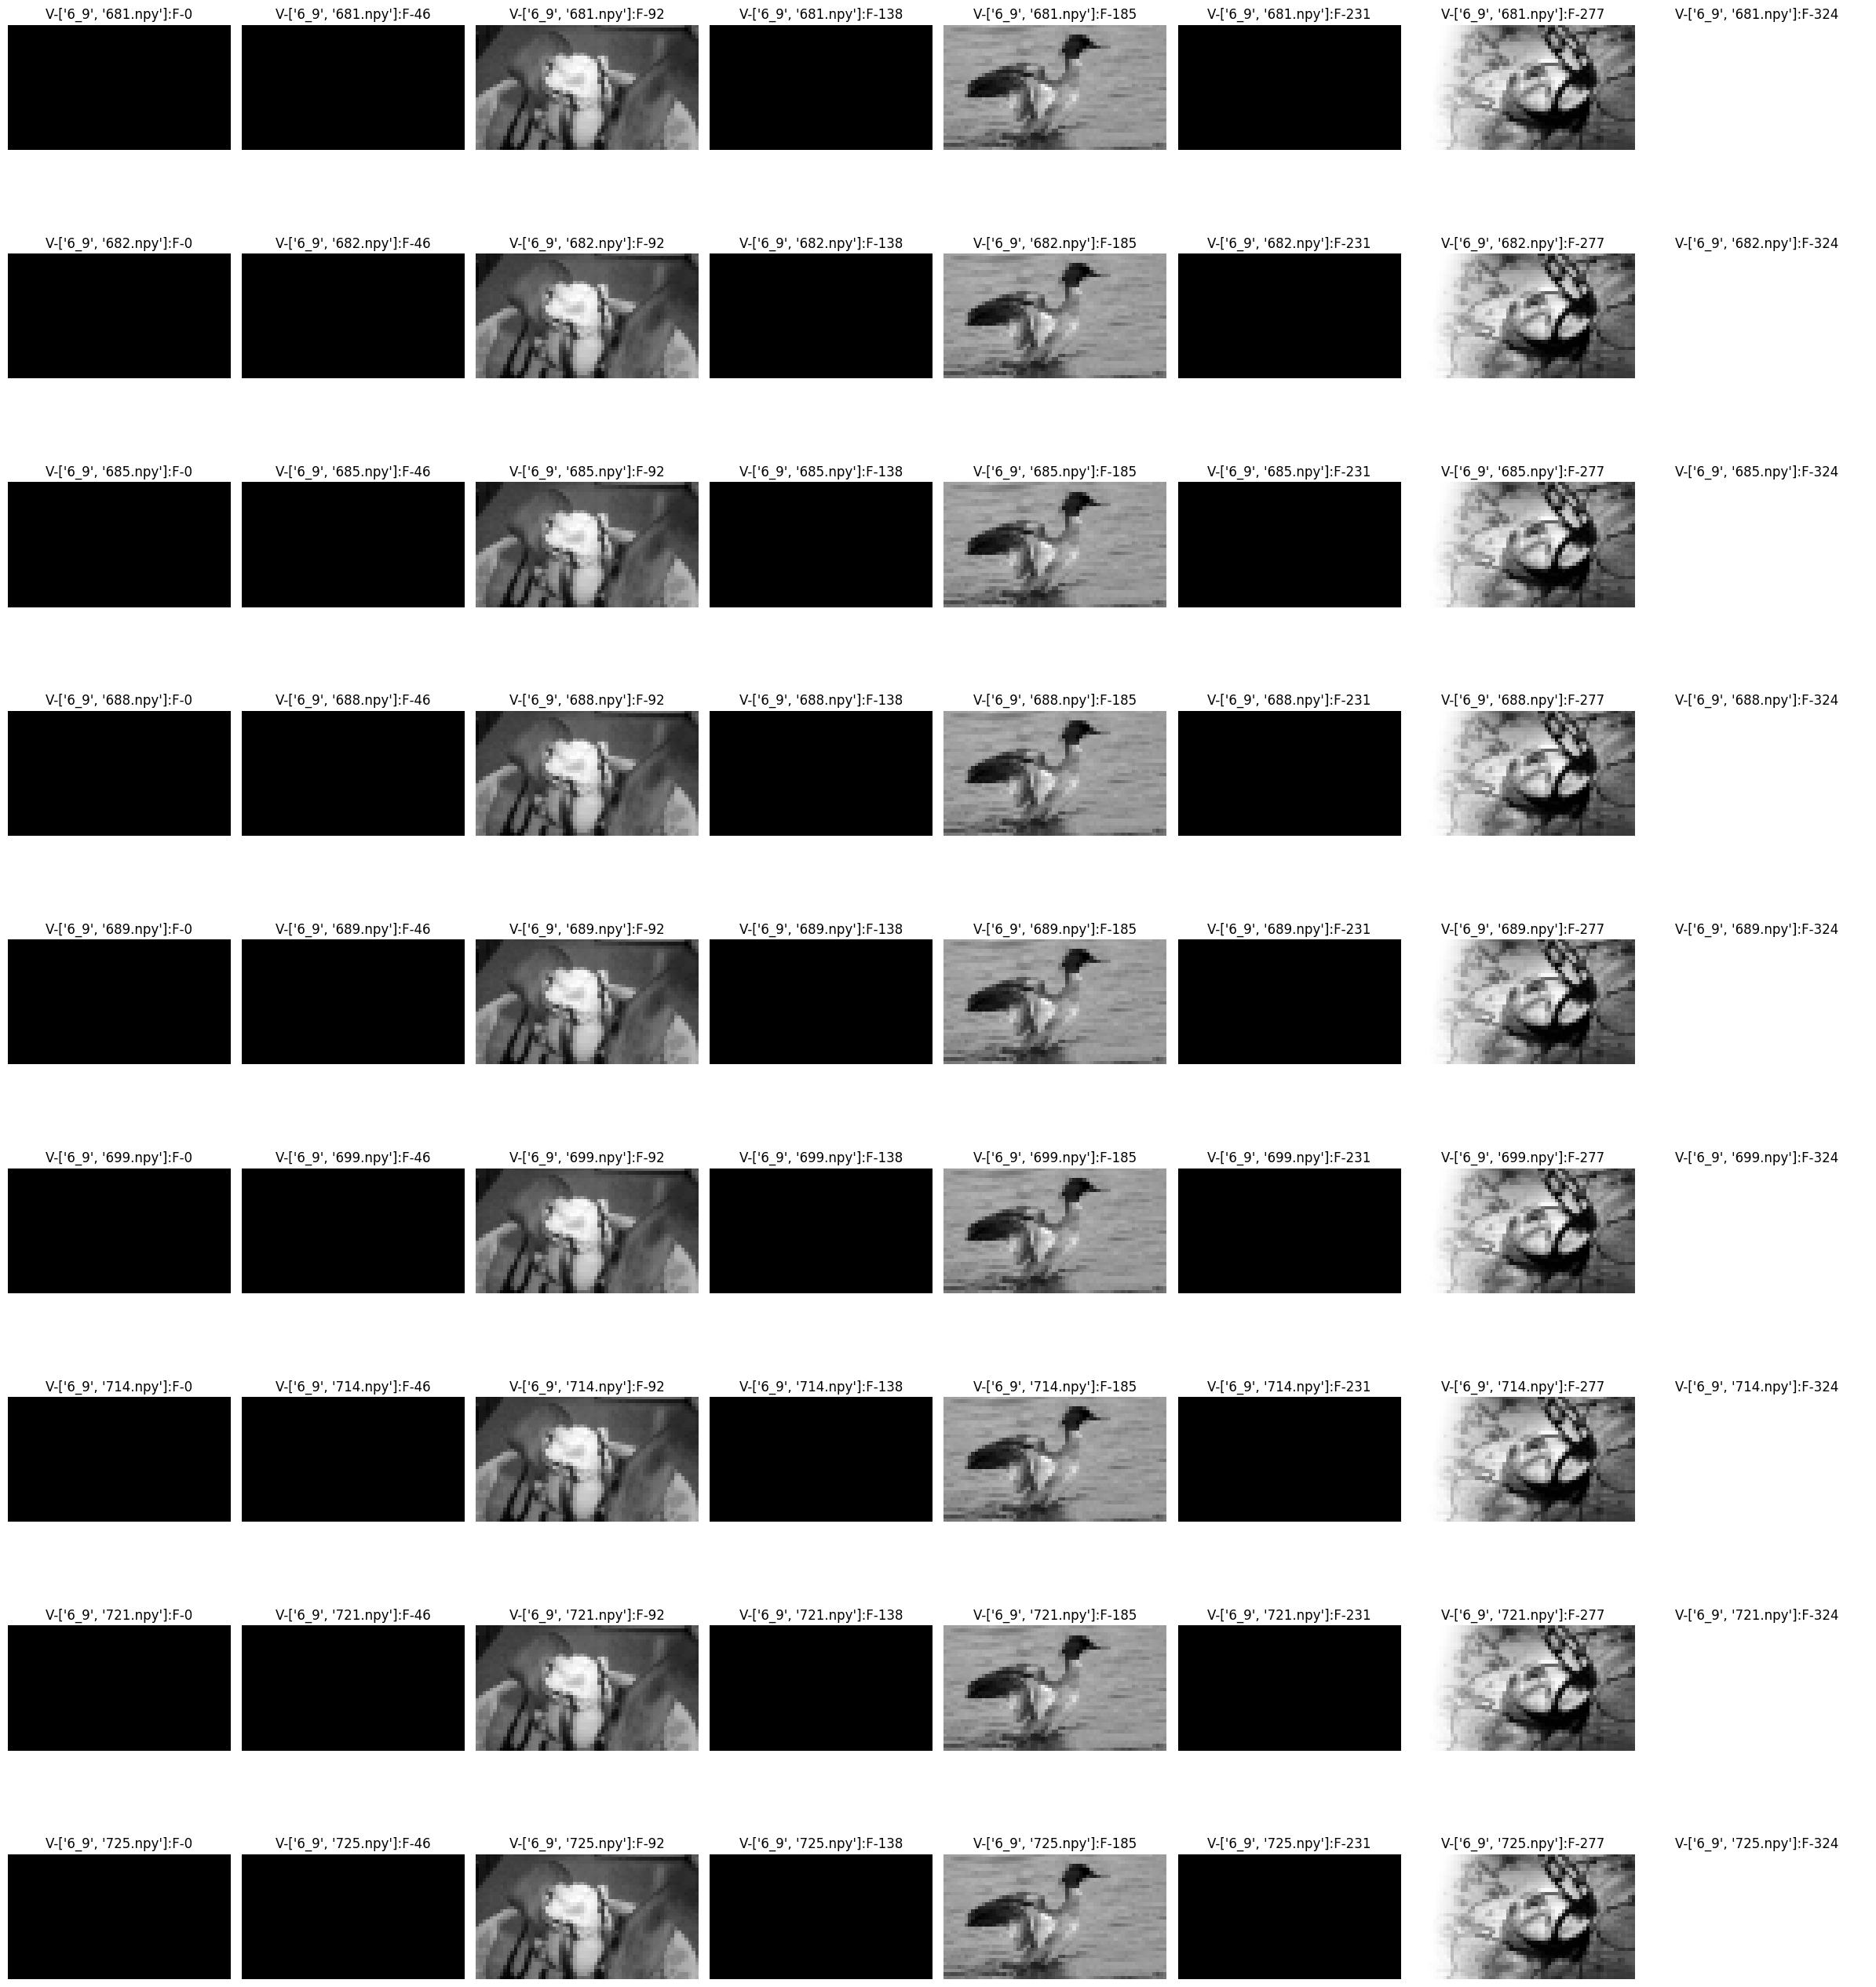

In [ ]:
vid_common_path  = "/content/drive/MyDrive/PROJECTS_2025/MDMC_SISSA/COURSES/Applied-AI/Dataframes/Mice_Merged_Videos/"
video_ref = vid_common_path + "Mouse_3__6_9__681.npy"
vid_dup_1 = vid_common_path + "Mouse_3__6_9__682.npy"
vid_dup_2 = vid_common_path + "Mouse_3__6_9__685.npy"
vid_dup_3 = vid_common_path + "Mouse_3__6_9__688.npy"
vid_dup_4 = vid_common_path + "Mouse_3__6_9__689.npy"
vid_dup_5 = vid_common_path + "Mouse_3__6_9__699.npy"
vid_dup_6 = vid_common_path + "Mouse_3__6_9__714.npy"
vid_dup_7 = vid_common_path + "Mouse_3__6_9__721.npy"
vid_dup_8 = vid_common_path + "Mouse_3__6_9__725.npy"
videos_path = [video_ref, vid_dup_1, vid_dup_2, vid_dup_3, vid_dup_4, vid_dup_5, vid_dup_6, vid_dup_7, vid_dup_8]
plot_videos_grid(videos_path)